In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam, Adagrad, RMSprop, SGD
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Checking for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# Transforms
transformer = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 requires input size (224, 224)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Path for training, validation, and test directories
train_path = '/content/drive/MyDrive/TFR_data/TFR_data/CWT_Data/CWT_train'
val_path = '/content/drive/MyDrive/TFR_data/TFR_data/CWT_Data/CWT_validation'
test_path = '/content/drive/MyDrive/TFR_data/TFR_data/CWT_Data/CWT_test'

In [ ]:
# Counting data samples
train_count = len(glob.glob(os.path.join(train_path, '*/*.png')))
val_count = len(glob.glob(os.path.join(val_path, '*/*.png')))
test_count = len(glob.glob(os.path.join(test_path, '*/*.png')))
print(f"Number of samples in the training set: {train_count}")
print(f"Number of samples in the validation set: {val_count}")
print(f"Number of samples in the test set: {test_count}")

Number of samples in the training set: 800
Number of samples in the validation set: 100
Number of samples in the test set: 100


In [ ]:
# Define batch size
batch_size = 32

In [ ]:
# Create datasets and dataloaders for training, validation, and test
train_dataset = torchvision.datasets.ImageFolder(train_path, transform=transformer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torchvision.datasets.ImageFolder(val_path, transform=transformer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=transformer)


In [ ]:
# Categories
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['AF_train', 'NSR_train']


In [ ]:
pip install torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionNet(nn.Module):
    def __init__(self, num_classes=2):
        super(InceptionNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 80, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Adjusting the input size of the first linear layer based on the output size of the last convolutional layer
        self.fc_input_size = 80 * 28 * 28  # Output size after the convolutional layers and pooling
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output of the convolutional layers
        x = torch.flatten(x, 1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x




# Load the model
model = InceptionNet(num_classes=2)
model.to(device)


InceptionNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=62720, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
# Define optimizers (Adam, AdaGrad, RMSprop, SGD)
optimizers = {
    "Adam": Adam(model.parameters(), lr=0.001),
    "Adagrad": Adagrad(model.parameters(), lr=0.001),
    "RMSprop": RMSprop(model.parameters(), lr=0.001),
    "SGD": SGD(model.parameters(), lr=0.001)
}

criterion = nn.CrossEntropyLoss()

In [ ]:
# Dictionaries for storing losses and accuracies
train_losses = {key: [] for key in optimizers.keys()}
val_losses = {key: [] for key in optimizers.keys()}
train_accuracies = {key: [] for key in optimizers.keys()}
val_accuracies = {key: [] for key in optimizers.keys()}
best_accuracy = {key: 0 for key in optimizers.keys()}

Training with optimizer: Adam
Epoch 1/5 - Train Loss: 1.1329, Train Acc: 0.4825, Val Loss: 0.6931, Val Acc: 0.5000
Epoch 2/5 - Train Loss: 0.6934, Train Acc: 0.4825, Val Loss: 0.6932, Val Acc: 0.5000
Epoch 3/5 - Train Loss: 0.6942, Train Acc: 0.4975, Val Loss: 0.6932, Val Acc: 0.5000
Epoch 4/5 - Train Loss: 0.6933, Train Acc: 0.5000, Val Loss: 0.6932, Val Acc: 0.5000
Epoch 5/5 - Train Loss: 0.6939, Train Acc: 0.5000, Val Loss: 0.6932, Val Acc: 0.5000
Training with optimizer: Adagrad
Epoch 1/5 - Train Loss: 0.6937, Train Acc: 0.4838, Val Loss: 0.6931, Val Acc: 0.5000
Epoch 2/5 - Train Loss: 0.6932, Train Acc: 0.4975, Val Loss: 0.6931, Val Acc: 0.5000
Epoch 3/5 - Train Loss: 0.6933, Train Acc: 0.4825, Val Loss: 0.6931, Val Acc: 0.5000
Epoch 4/5 - Train Loss: 0.6932, Train Acc: 0.5075, Val Loss: 0.6931, Val Acc: 0.5000
Epoch 5/5 - Train Loss: 0.6932, Train Acc: 0.4950, Val Loss: 0.6931, Val Acc: 0.5000
Training with optimizer: RMSprop
Epoch 1/5 - Train Loss: 1.6763, Train Acc: 0.4975, Val

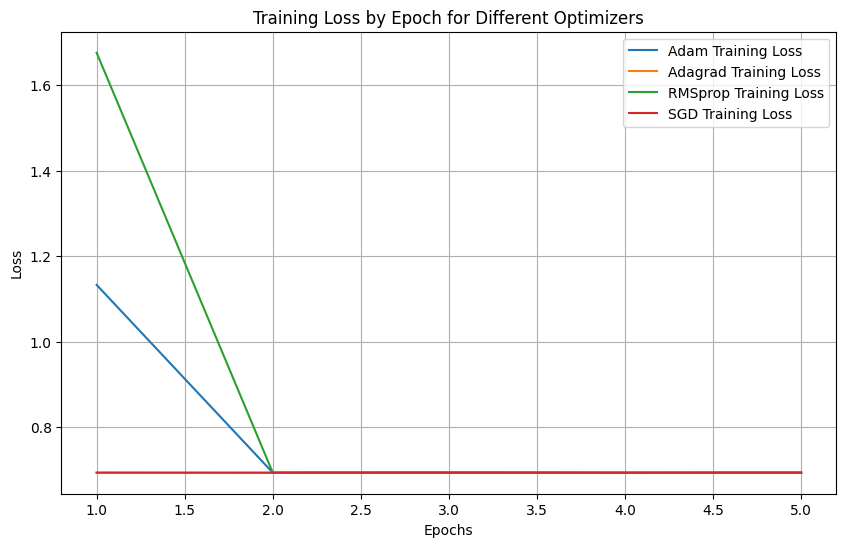

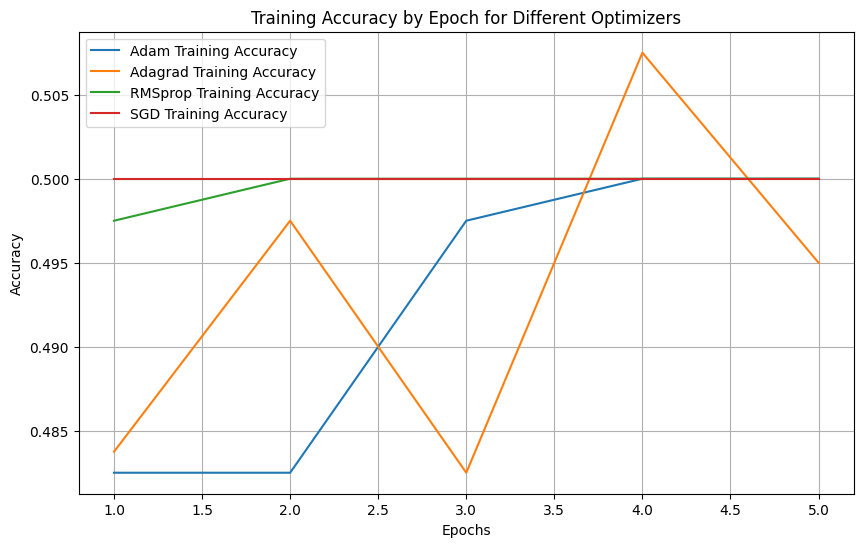

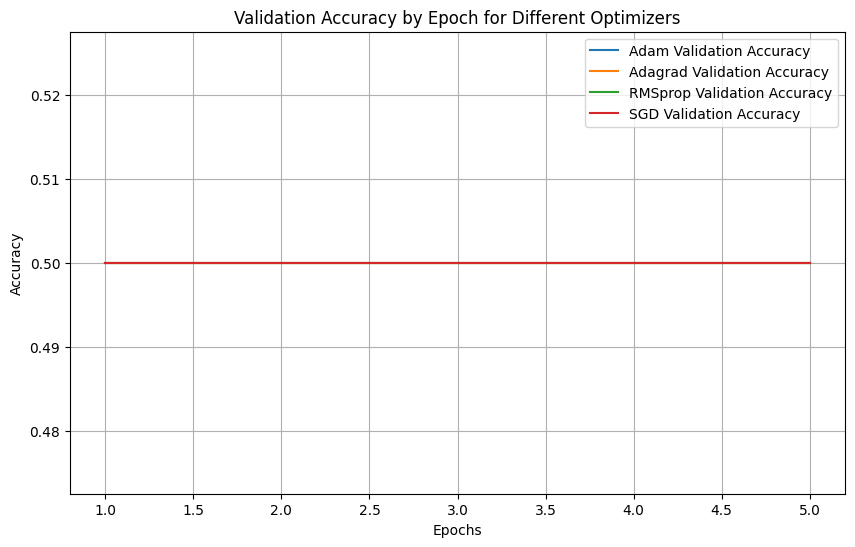

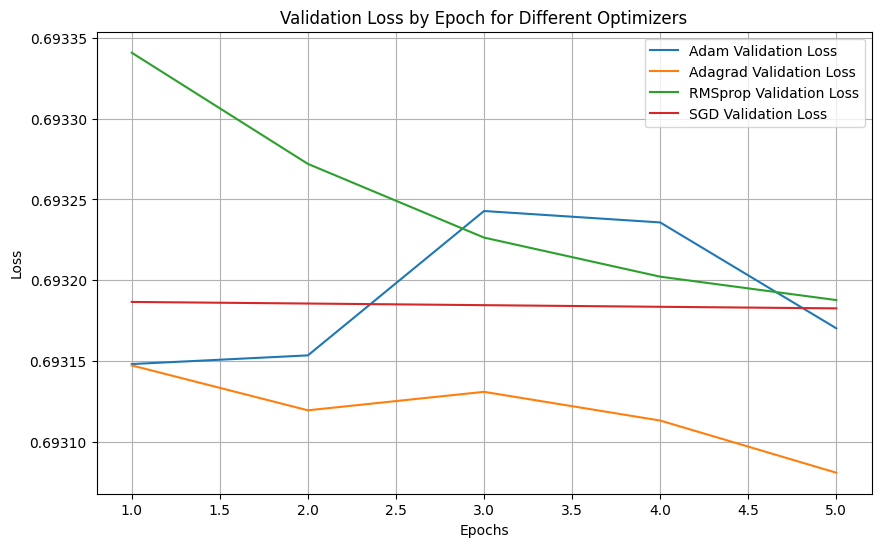

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Assuming the necessary model, device, train_loader, val_loader and other required elements are defined.

# Initialize dictionaries to store the loss and accuracy data
train_losses_dict = {}
train_accuracies_dict = {}
val_losses_dict = {}
val_accuracies_dict = {}

# Training loop for each optimizer
for opt_name, optimizer in optimizers.items():
    print(f"Training with optimizer: {opt_name}")
    model.train()  # Reset to training mode

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_accuracy[opt_name] = 0  # Initialize best accuracy to 0

    for epoch in range(5):
        running_loss, running_corrects, num_samples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            num_samples += labels.size(0)

        epoch_loss = running_loss / num_samples
        epoch_acc = running_corrects.double() / num_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        # Validation phase inside the epoch loop
        model.eval()  # Set model to evaluation mode
        val_loss, val_corrects, val_samples = 0.0, 0, 0

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_loss += loss.item() * images.size(0)
                val_samples += labels.size(0)

        val_loss /= val_samples
        val_losses.append(val_loss)
        val_acc = val_corrects.double() / val_samples
        val_accuracies.append(val_acc.item())

        print(f"Epoch {epoch+1}/5 - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save model if accuracy improves
        if val_acc > best_accuracy[opt_name]:
            best_accuracy[opt_name] = val_acc
            torch.save(model.state_dict(), f'inceptionnet_{opt_name}_best_model.pth')

    # Collecting loss and accuracy data in dictionaries for plotting
    train_losses_dict[opt_name] = train_losses
    train_accuracies_dict[opt_name] = train_accuracies
    val_losses_dict[opt_name] = val_losses
    val_accuracies_dict[opt_name] = val_accuracies

# Plotting sections for loss and accuracy
plt.figure(figsize=(10, 6))
for opt_name, losses in train_losses_dict.items():
    plt.plot(range(1, 6), losses, label=f'{opt_name} Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss by Epoch for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for opt_name, accuracies in train_accuracies_dict.items():
    plt.plot(range(1, 6), accuracies, label=f'{opt_name} Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy by Epoch for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for opt_name, accuracies in val_accuracies_dict.items():
    plt.plot(range(1, 6), accuracies, label=f'{opt_name} Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy by Epoch for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for opt_name, losses in val_losses_dict.items():
    plt.plot(range(1, 6), losses, label=f'{opt_name} Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss by Epoch for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()

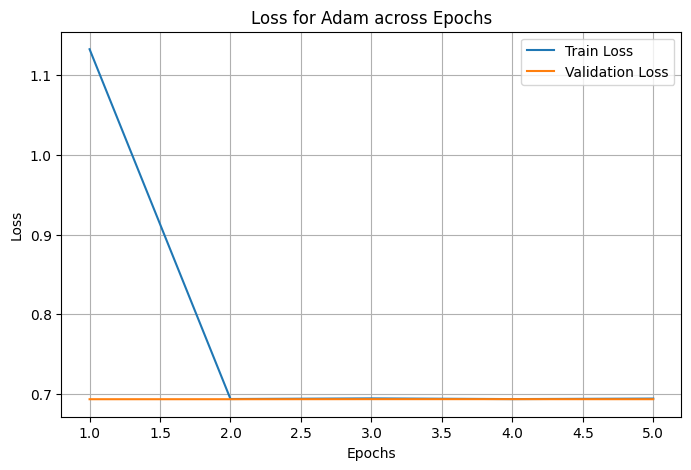

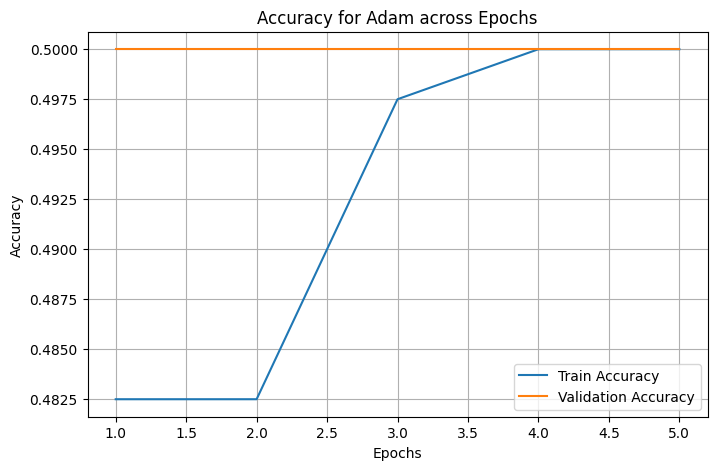

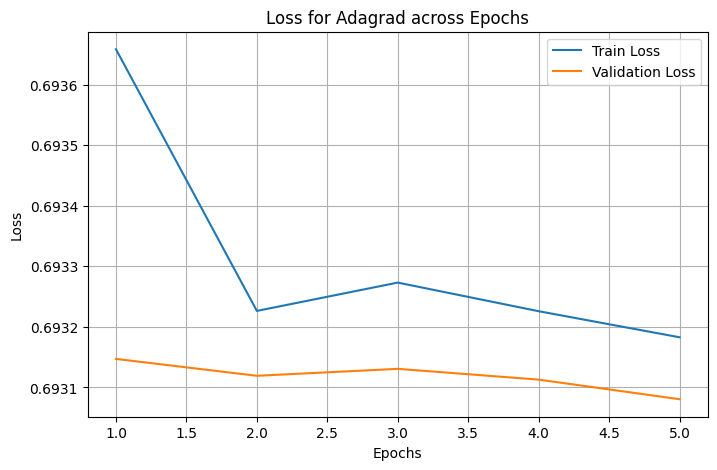

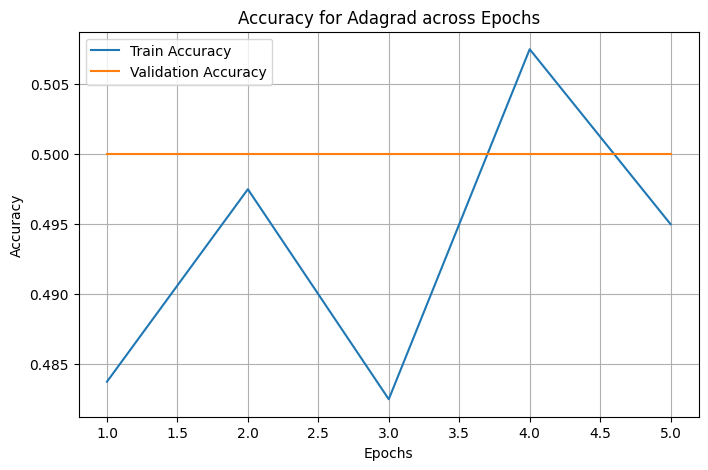

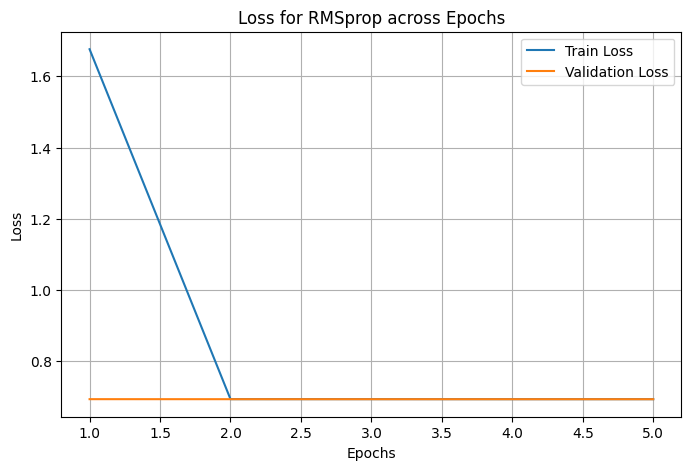

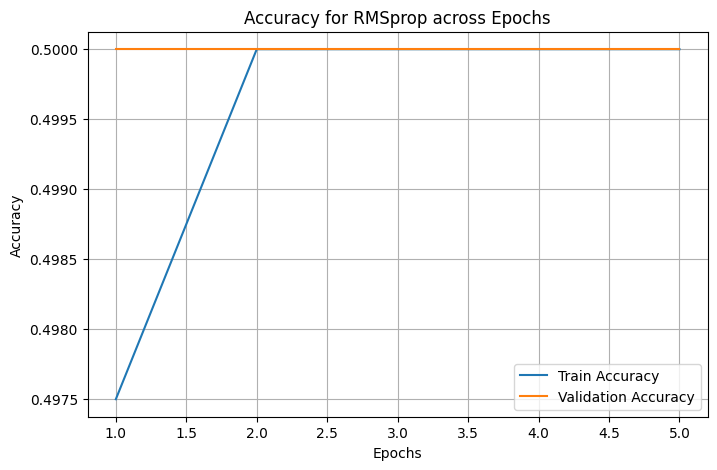

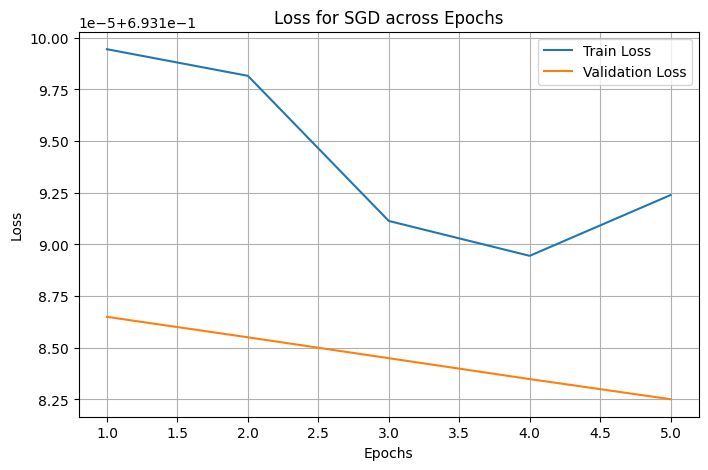

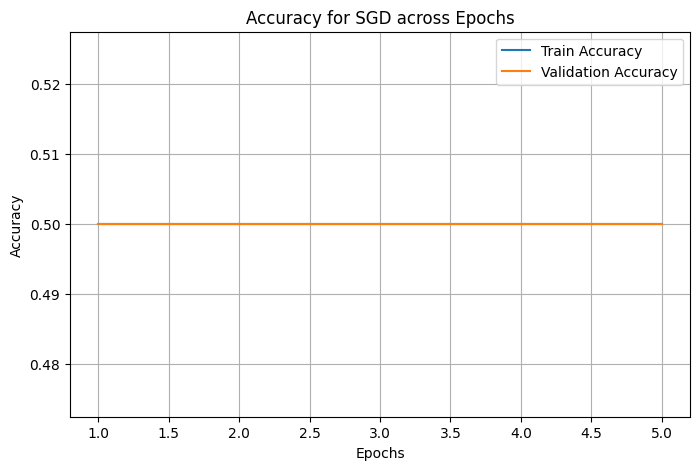

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming the training and validation data dictionaries are already populated as previously discussed.

# Define a function to plot data for each optimizer
def plot_metrics(optimizer_name, train_data, val_data, metric_name, ylabel):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 6), train_data[optimizer_name], label=f'Train {metric_name}')
    plt.plot(range(1, 6), val_data[optimizer_name], label=f'Validation {metric_name}')
    plt.title(f'{metric_name} for {optimizer_name} across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Loop through each optimizer to generate separate plots for each metric
for opt_name in optimizers.keys():
    plot_metrics(opt_name, train_losses_dict, val_losses_dict, 'Loss', 'Loss')
    plot_metrics(opt_name, train_accuracies_dict, val_accuracies_dict, 'Accuracy', 'Accuracy')


In [ ]:
import os
import csv
import pandas as pd
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Assuming you have defined the necessary model, device, test_path, transformer, and batch_size.

# Load the test dataset
test_dataset = ImageFolder(test_path, transform=transformer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the trained model
model = InceptionNet(num_classes=2)  # Assuming ResNet50 is defined as per your previous code
model.load_state_dict(torch.load('/content/inceptionnet_Adagrad_best_model.pth', map_location=device))
model.eval()

# Initialize lists to store predictions
image_ids = [os.path.basename(path) for path, _ in test_dataset.imgs]  # Extract file paths
true_labels = []
predicted_labels = []

# Iterate through the test dataset and make predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Store predictions
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Print predictions for image ID, true labels, and predicted labels
print("Image ID\tTrue Label\tPredicted Label")
for i in range(len(image_ids)):
    print(f"{image_ids[i]}\t{true_labels[i]}\t{predicted_labels[i]}")

# Save predictions as a CSV file
predictions_data = {'Image ID': image_ids, 'True Label': true_labels, 'Predicted Label': predicted_labels}
predictions_df = pd.DataFrame(predictions_data)
predictions_df.to_csv('predictions.csv', index=False)

print("Predictions saved as predictions.csv")



Image ID	True Label	Predicted Label
ecg_cwt_image_JS01521_I.png	0	0
ecg_cwt_image_JS01535_I.png	0	0
ecg_cwt_image_JS01545_I.png	0	0
ecg_cwt_image_JS01572_I.png	0	0
ecg_cwt_image_JS01575_I.png	0	0
ecg_cwt_image_JS01583_I.png	0	0
ecg_cwt_image_JS01595_I.png	0	0
ecg_cwt_image_JS01597_I.png	0	0
ecg_cwt_image_JS01598_I.png	0	0
ecg_cwt_image_JS01606_I.png	0	0
ecg_cwt_image_JS01613_I.png	0	0
ecg_cwt_image_JS01643_I.png	0	0
ecg_cwt_image_JS01681_I.png	0	0
ecg_cwt_image_JS01702_I.png	0	0
ecg_cwt_image_JS01714_I.png	0	0
ecg_cwt_image_JS01735_I.png	0	0
ecg_cwt_image_JS01746_I.png	0	0
ecg_cwt_image_JS01757_I.png	0	0
ecg_cwt_image_JS01819_I.png	0	0
ecg_cwt_image_JS01868_I.png	0	0
ecg_cwt_image_JS01882_I.png	0	0
ecg_cwt_image_JS01937_I.png	0	0
ecg_cwt_image_JS01985_I.png	0	0
ecg_cwt_image_JS01995_I.png	0	0
ecg_cwt_image_JS02032_I.png	0	0
ecg_cwt_image_JS02059_I.png	0	0
ecg_cwt_image_JS02091_I.png	0	0
ecg_cwt_image_JS02118_I.png	0	0
ecg_cwt_image_JS02136_I.png	0	0
ecg_cwt_image_JS02161_I.png	0	0
ecg_

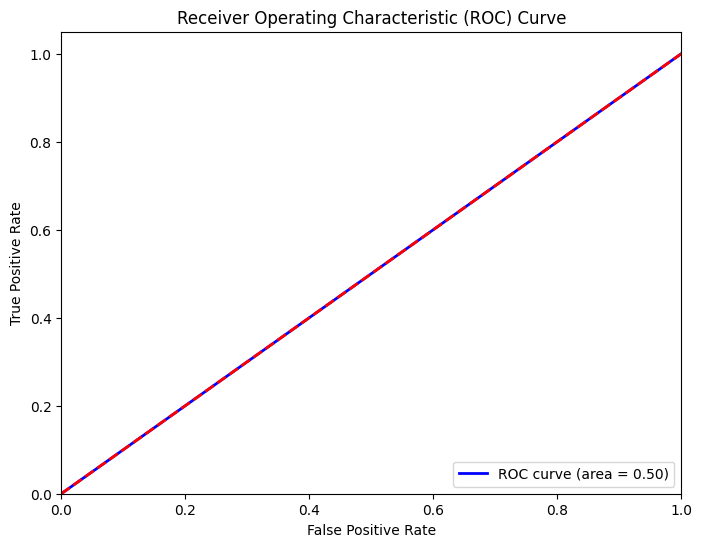

Overall Test Accuracy: 0.5
Confusion Matrix:
[[50  0]
 [50  0]]
Sensitivity (Recall): 0.0
Specificity: 1.0
F1-score: 0.0


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate overall test accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate sensitivity (recall) and specificity
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()
sensitivity = recall_score(true_labels, predicted_labels)
specificity = true_negatives / (true_negatives + false_positives)

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print results
print("Overall Test Accuracy:", test_accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)
print("F1-score:", f1)
